# Cross Validation and Regularized Regression

### Jack Bennetto

## Objectives

By the end of the day you should be able to

 * State the purpose of Lasso and Ridge regression
 * Choose the regularization hyperparameter with cross validation
 * Perform standardization and normalization, and explain why it is needed with regularization

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In recent days we've talked about linear regression, in which we find the coefficients $\beta_0$, $\beta_1$, ..., $\beta_p$ to minimize

$$RSS = \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2$$

In **Ridge Regession** we find the values to minimize

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right) \right)^2 + \alpha \sum_{j=1}^{p} \beta_j^2$$

Effectively we've penalizing extreme values of $\beta$
Note that we aren't including $\beta_0$. The value $\alpha$ is a hyperparameter of the model.

Question: how should we decide the appropriate value for $\alpha$?

In **LASSO Regession** (**L**east **A**bsolute **S**hrinkage and **S**election **O**perator) we find the values to minimize

$$ \sum_{i=1}^n \left( y_i - \left(\beta_0 + \sum_{j=1}^p \beta_j x_{ij} \right)\right)^2 + \alpha \sum_{j=1}^{p} | \beta_j |$$

In many ways this is similar to Ridge:
  * We're penalizing large values of $\beta$.
  * We aren't including $\beta_0$.
  * We have a hyperparameter $\alpha$.

The difference is the exponent. Ridge is sometimes known as **L2 regularization**, while LASSO is **L1 regularization**. We'll talk more about this in a bit.

Questions:

What does this mean if $\alpha = 0$?

What does this mean if $\alpha \to \infty$

How does this relate to the bias-variance trade-off? If $\alpha$ increases, what happens to the bias? What happens to the variance?

### An Example

Let's use the cars dataset to investigate, predicting the mpg from the other features.

In [3]:
cars = pd.read_csv('cars.csv')

In [4]:
cars = cars[cars.horsepower != '?']
cars.horsepower = cars.horsepower = cars.horsepower.astype('float64')

In [5]:
columns = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model']
x = cars[columns]
y = cars['mpg']

We can look at the how the coefficients depend on various values of $\lambda$.

N.B.: the coefficient in `sklearn` is called $\alpha$.

In [9]:
nalphas = 50
min_alpha_exp = -3
max_alpha_exp = 1.5
nfeatures = 6
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
for i, alpha in enumerate(alphas):
    #model = Pipeline([('standardize', StandardScaler()),
    #                  ('lasso', Lasso(alpha=alpha))])
    model = Lasso(alpha=alpha)
    model.fit(x, y)
    #coefs[i] = model.steps[1][1].coef_
    coefs[i] = model.coef_

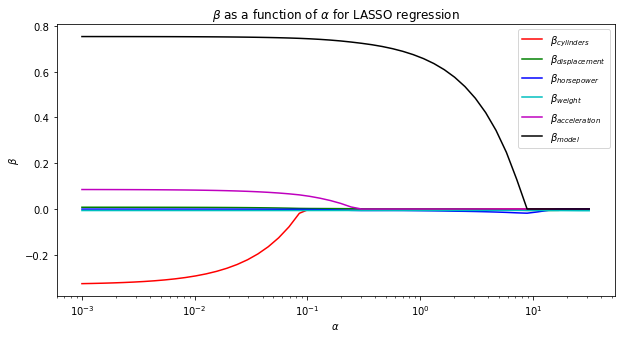

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
for feature, color in zip(range(nfeatures),
                          ['r','g','b','c','m','k']):
    plt.plot(alphas, coefs[:, feature],
             color=color,
             label="$\\beta_{{{}}}$".format(columns[feature]))
ax.set_xscale('log')
ax.set_title("$\\beta$ as a function of $\\alpha$ for LASSO regression")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="upper right")

Discussion: What's going on?

In [11]:
nalphas = 50
min_alpha_exp = 0
max_alpha_exp = 6
coefs = np.zeros((nalphas, nfeatures))
alphas = np.logspace(min_alpha_exp, max_alpha_exp, nalphas)
for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha)
    model.fit(x, y)
    coefs[i] = model.coef_

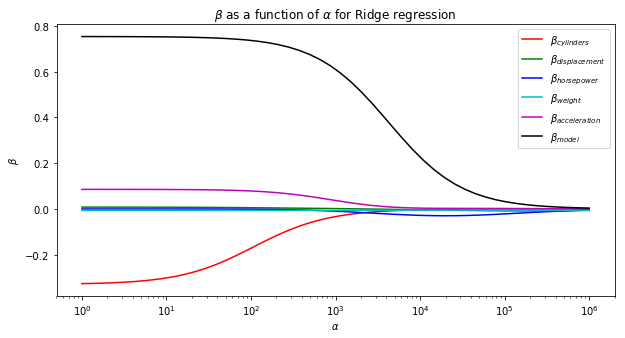

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
for feature, color in zip(range(nfeatures),
                          ['r','g','b','c','m','k']):
    plt.plot(alphas, coefs[:, feature],
             color=color,
             label="$\\beta_{{{}}}$".format(columns[feature]))

ax.set_xscale('log')
ax.set_title("$\\beta$ as a function of $\\alpha$ for Ridge regression")
ax.set_xlabel("$\\alpha$")
ax.set_ylabel("$\\beta$")
ax.legend(loc="upper right")

Discussion: what's going on? How does this differ from LASSO?

In [13]:
def draw_circle(ax, radius, color, x=0, y=0):
    ax.add_artist(plt.Circle((x, y),
                             radius,
                             color=color,
                             fill=False))
def draw_diamond(ax, radius, color, x=0, y=0):
    ax.add_artist(plt.Polygon([(x, radius+y),
                               (radius+x, y),
                               (x, -radius+y),
                               (-radius+x, y)],
                              color=color,
                              fill=False))

To help understand this, consider the contour plots of the lost functions.

(-8, 8)

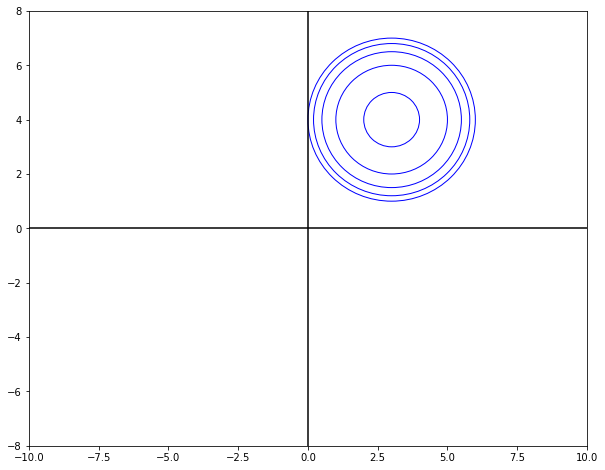

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.axhline(0, color='k')
ax.axvline(0, color='k')

for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
    draw_circle(ax, r, 'b', 3, 4)

#for r in [1.0, 2.0, 2.5, 2.8, 3.0]:
#    draw_circle(ax, r, 'b', 1.3, 4)

#for r in [1.0, 1.4, 1.7, 2.0]:
#    draw_circle(ax, r, 'g')

#for r in [0.7, 1.3, 2, 2.7]:
#    draw_diamond(ax, r, 'g')

    
#for r in [0.7, 1.3]:
#    draw_diamond(ax, r, 'g')

ax.set_xlim(-10, 10)
ax.set_ylim(-8, 8)

### Scaling and regularization

Over the next couple weeks we'll talk about a variety of predictive models, and various ways in which they are different. One of those is whether it is necessary to standardize/normalize the features before fitting. First, some definitions:

**Standarization** (in this context) is the proccess of subtracting the mean from eah feature, and then dividing my the standard deviation, so each feature has a mean of 0 and standard deviation of 1.

**Normalization** (again, in this context) is the process of subtracting the minimum value from each feature, and then dividing my the maximum, so each feature ranges from 0 to 1.

Both accomplish the same purpose, of having all features on the same scale.

Ok, so for some models you need to standardize (or normalize) the features before fitting the model, at least if they have significantly different ranges. It's not that hard to write code to do that, but the transformers in `sklearn` make that a lot easier.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

model = Pipeline([('standardize', StandardScaler()),
                   ('regressor', Lasso())])

The pipeline model will take care of the transformations in fitting and prediction automatically. You can normalize using `sklearn.preprocessing.MinMaxScaler`.

In usual linear regression without regularization, scaling **does not matter**. If you multiply change the scale of a feature, it will change the cooresponding coefficient, but the predictions will be exactly the same.

This changes when we add regularization. Since we include a term that is proportional to the $\beta$, that actual predictions will change it we rescale the values.

As a rule of thumb, if rescaling the values will change the predictions of a model, you need to standardize (or normalize) the values.

Discussion: is standardizing or normalizing better? When should you do one or the other?